<a href="https://colab.research.google.com/github/tayfununal/Uniform-Autoencoder-with-Latent-Flow-Matching/blob/main/UAE-with-LFM/generation/moon_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/tayfununal/Uniform-Autoencoder-with-Latent-Flow-Matching.git

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import Tensor

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import os

print(os.getcwd())

%run /content/Uniform-Autoencoder-with-Latent-Flow-Matching/models/moon_model.ipynb
%run /content/Uniform-Autoencoder-with-Latent-Flow-Matching/datasets/moon_dataset.ipynb

# Call the Flow model
%run /content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/models/moon_flow_model.ipynb

plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [17]:
# Hyper-Parameters & Settings
dataset_size = 2000
batch_size = 1000

In [18]:
# Dataset
test_dataset = MoonDataset(mode='test', n_samples=dataset_size)

# DataLoader
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [19]:
# Load the UAE model

path = '/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/moon/UAE_Moon'
model = torch.load(path + '.model', weights_only=False)
model.eval()

To_Uniform(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SiLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): SiLU()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): SiLU()
    (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SiLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): SiLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
    (7): Sigmoid()
  )
)

# Evaluation

In [20]:
# Create the "results" folder
os.makedirs("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/moon", exist_ok=True)

flow_name = '/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/moon/UAE_Latent_FM'
flow = torch.load(flow_name + '.model', weights_only=False)
flow.eval()

Flow(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=1, bias=True)
  )
)

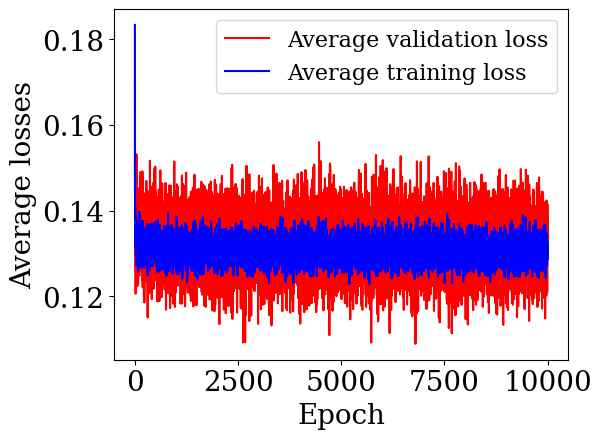

In [27]:
# Load the losses
losses = np.loadtxt("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/moon/losses.csv", delimiter=",", skiprows=1)
train_losses = losses[:, 0]
val_losses = losses[:, 1]

# Create a plot
plt.plot(val_losses, label="Average validation loss", c="red")
plt.plot(train_losses, label="Average training loss", c="blue")

plt.xlabel("Epoch")
plt.ylabel("Average losses")
plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/moon/average_losses_per_epoch.pdf")
plt.show()

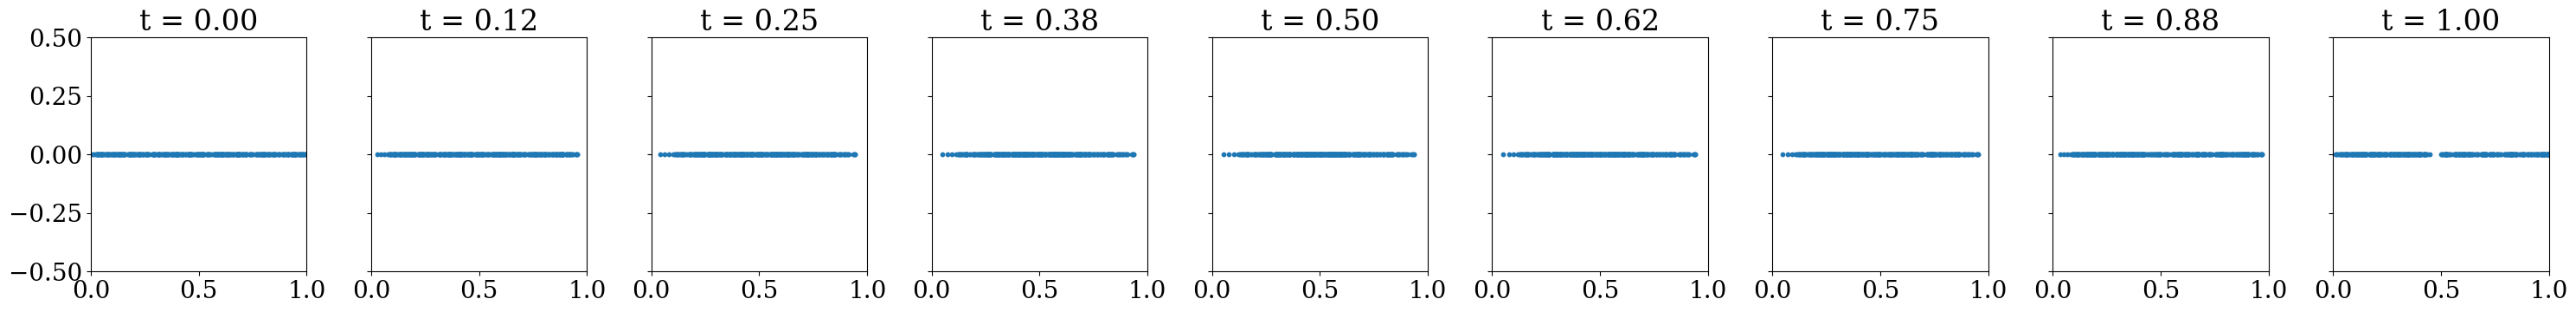

In [34]:
x_test, _ = test_dataset[:]

x_uniform = torch.rand(len(x_test), 1)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x_uniform.detach().numpy(), np.zeros_like(x_uniform.detach().numpy()),s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(0.0, 1.0)
axes[0].set_ylim(-0.5, 0.5)

for i in range(n_steps):
    x_uniform = flow.step(x_t=x_uniform, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x_uniform.detach().numpy(), np.zeros_like(x_uniform.detach().numpy()), s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.savefig("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/moon/moon_FM_latent_result_along_time.pdf")
plt.show()

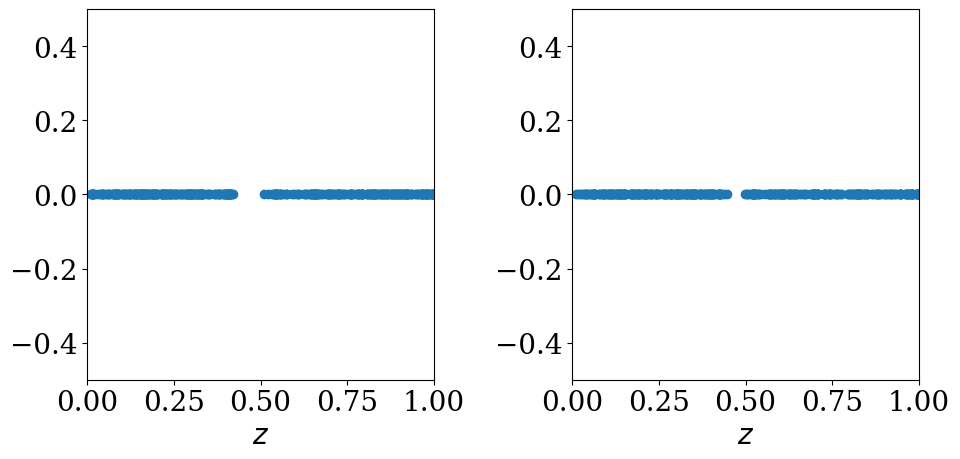

In [36]:
x_test,_ = test_dataset[:]
x_test = model.encoder(x_test)

# Flow Matching Results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left plot - UAE
axs[0].scatter(x_test.detach().numpy(), np.zeros_like(x_test.detach().numpy()), alpha=1)
axs[0].set_xlim(0.0, 1.0)
axs[0].set_ylim(-0.5, 0.5)
axs[0].set_xlabel('$z$')

# Right plot - Flow Matching
axs[1].scatter(x_uniform.detach().numpy(), np.zeros_like(x_uniform.detach().numpy()),alpha=1)
axs[1].set_xlim(0.0, 1.0)
axs[1].set_ylim(-0.5, 0.5)
axs[1].set_xlabel('$z$')

plt.tight_layout()

plt.savefig("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/moon/UAE_latent_vs_FM_latent.pdf")
plt.show()

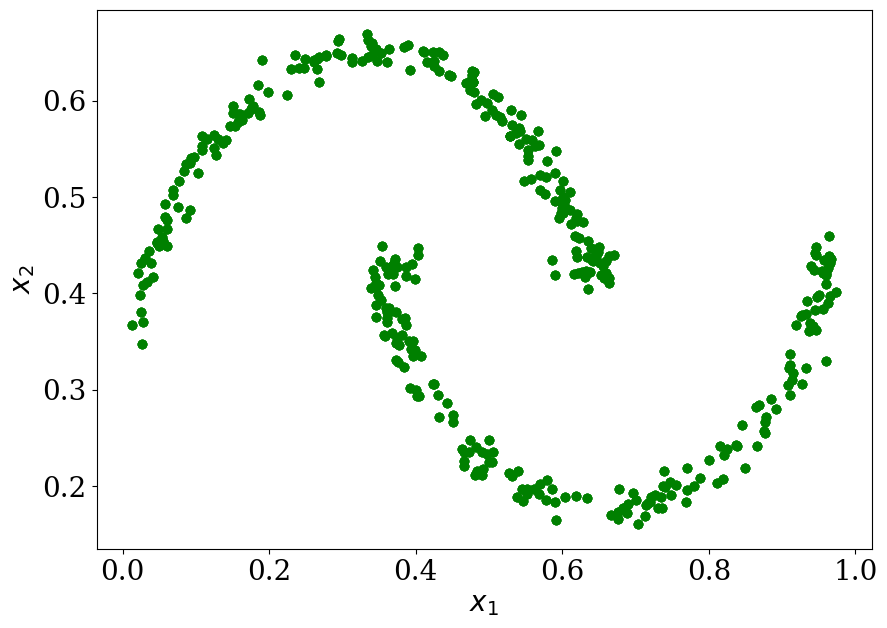

In [73]:
import plotly.express as px
import pandas as pd

new_data = model.decode(x_uniform)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)


for i in range(4):
    ax.scatter(new_data[:, 0].detach().numpy(),
               new_data[:, 1].detach().numpy(), color='green', alpha=1)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.savefig("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/moon/latent_flowMatching_uniform_to_moon.pdf")
plt.show()